#### DATA

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tthien/shanghaitech-with-people-density-map
! unzip shanghaitech-with-people-density-map.zip

Streaming output truncated to the last 5000 lines.
  inflating: ShanghaiTech/part_B/test_data/images/IMG_199.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_2.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_20.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_200.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_201.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_202.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_203.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_204.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_205.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_206.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_207.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_208.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_209.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_21.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_210

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy
from scipy.io import loadmat
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import h5py
import torch
import shutil
import torch.nn as nn
from torchvision import models
import glob
from sklearn.model_selection import train_test_split
import json
from PIL import Image,ImageFilter,ImageDraw
from PIL import ImageStat
import random
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import sys
import warnings
from torch.autograd import Variable
from torchvision import datasets, transforms
import argparse
import time

#DENSITY MAPS

In [ ]:
def gen_density_map_gaussian(im, points, sigma=4):
    """
    func: generate the density map
    """
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map
    if sigma == 4:
        # Adaptive sigma in CSRNet.
        leafsize = 2048
        tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
        distances, _ = tree.query(points, k=4)
    for idx_p, p in enumerate(points):
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        gaussian_radius = sigma * 2 - 1
        if sigma == 4:
            # Adaptive sigma in CSRNet.
            sigma = max(int(np.sum(distances[idx_p][1:4]) * 0.1), 1)
            gaussian_radius = sigma * 3
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma),
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma).T
        )
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        gaussian_map = gaussian_map[y_up:y_down, x_left:x_right]
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        density_map[
            max(0, p[0]-gaussian_radius):min(h, p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(w, p[1]+gaussian_radius+1)
        ] += gaussian_map
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map

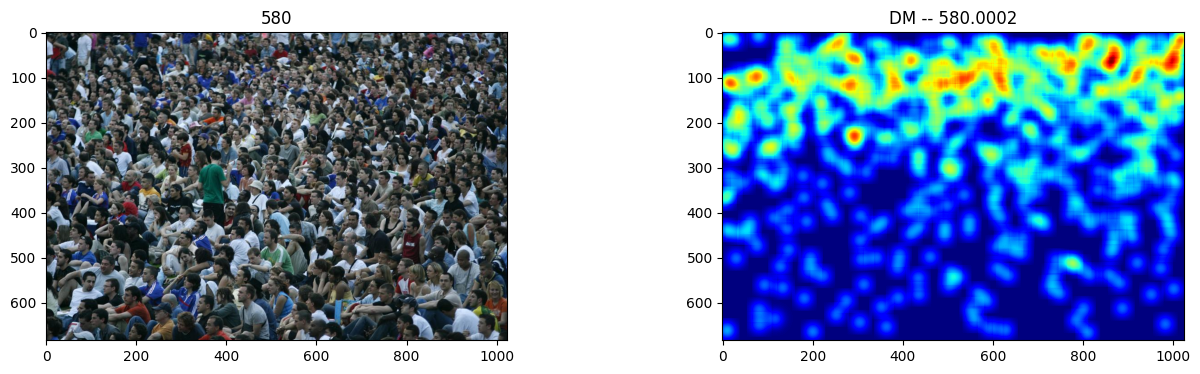

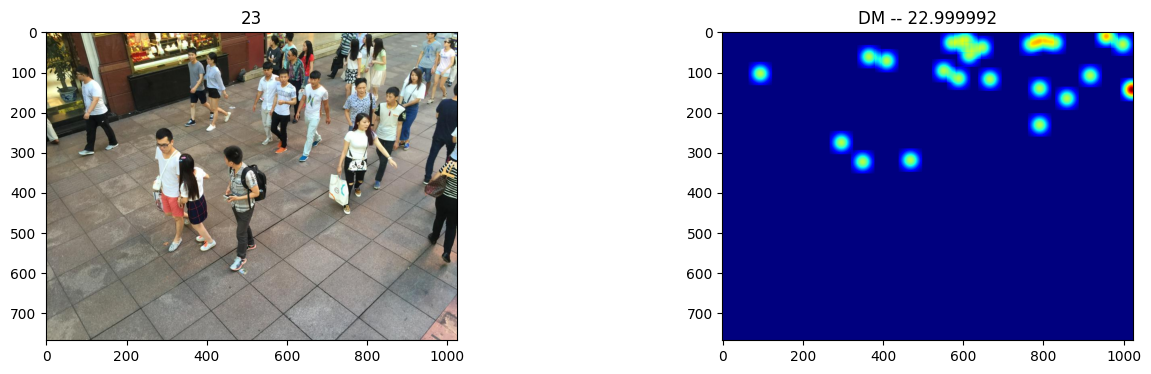

In [ ]:

img_paths = ['./shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_196.jpg',
             './shanghaitech_with_people_density_map/ShanghaiTech/part_B/test_data/images/IMG_1.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()

In [ ]:
print(os.listdir("./shanghaitech_with_people_density_map/ShanghaiTech"))

['part_B', 'part_A']


In [ ]:
DATA_PATH = "./shanghaitech_with_people_density_map/ShanghaiTech/part_B/train_data/"
TEST_DATA_PATH = "./shanghaitech_with_people_density_map/ShanghaiTech/part_B/test_data/"

In [ ]:
PRETRAINED_MODEL ='/content/drive/MyDrive/run_two_checkpoint_og.pth.tar'

In [ ]:
print(os.listdir(DATA_PATH))

['ground-truth-h5', 'images', 'ground-truth']


####Ground Truth

In [ ]:
## UTILS ##
def drawpix(im,pt):
  y = int(pt[0])
  x = int(pt[1])
  for i in range(x-4,x+5):
    for j in range(y-4,y+5):
      if(i<im.shape[0] and i>=0 and j<im.shape[1] and j>=0 and (i==x or j==y)):
        im[i,j] = (255,0,0)
  return im

In [ ]:
im = cv2.imread('./shanghaitech_with_people_density_map/ShanghaiTech/part_B/train_data/images/IMG_1.jpg')
pts = loadmat('./shanghaitech_with_people_density_map/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')['image_info'][0][0][0][0][0]

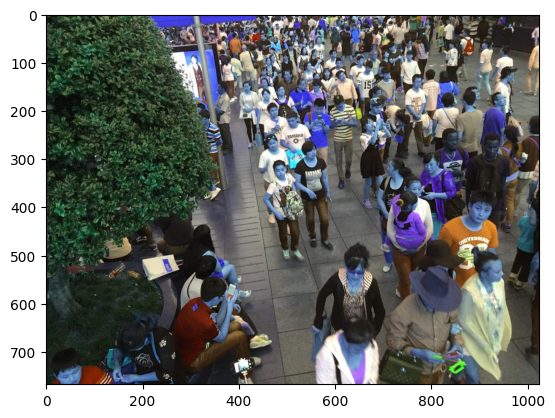

In [ ]:
plt.imshow(im)

In [ ]:
def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():
            param = torch.from_numpy(np.asarray(h5f[k]))
            v.copy_(param)

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename,'model_best.pth.tar')

#MODEL ARCHITECTURE

In [ ]:


class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(list(self.frontend.state_dict().items()))):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

#### to create image path lists

In [ ]:

def create_training_image_list(data_path):

    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val

#DATASET

In [ ]:
'''
get the image and the ground truth density map
'''
def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])

    target = cv2.resize(target,(int(target.shape[1]/8), int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64

    return img,target

In [ ]:
'''
create a Dataset using the list of image paths
'''

class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, seen=0, batch_size=1, num_workers=4):
        if train:
            root = root *4
        if shuffle:
            random.shuffle(root)

        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'

        img_path = self.lines[index]

        img,target = load_data(img_path,self.train)

        if self.transform is not None:
            img = self.transform(img)
        return img,target

# TRAINING


In [ ]:
VAL_LOSSES= []

In [ ]:
PRETRAINED_MODEL = None

In [ ]:
'''
hyperparameters
'''
BATCH_SIZE  = 1
MOMENTUM = 0.95
DECAY  = 5*1e-4
EPOCHS  = 10
SEED  = time.time()
BEST_PREC1= 1e6
PRINT_FREQ = 30
START_EPOCH = 0
EPOCHS  = 6
WORKERS  = 8
STEPS = [-1, 1, 100, 150]
SCALES  = [1,1,1,1]
PRE = PRETRAINED_MODEL
INITIAL_LR = 1e-7
LR  = INITIAL_LR
GPU = "0"

In [ ]:
'''
main function where the epoch loop and validation happens
'''
def main():
    global DECAY,EPOCHS,SEED,BEST_PREC1,START_EPOCH,EPOCHS,WORKERS,STEPS,SCALES,PRE,INITIAL_LR,GPU
    best_prec1 = 1e6

    os.environ['CUDA_VISIBLE_DEVICES'] = GPU
    torch.cuda.manual_seed(SEED)

    train_list, val_list = get_train_val_list(DATA_PATH)

    model = CSRNet()

    model = model.cuda()

    criterion = nn.MSELoss(size_average=False).cuda()

    optimizer = torch.optim.SGD(model.parameters(),LR,
                                momentum=MOMENTUM,
                                weight_decay=DECAY)

    if PRE:
        if os.path.isfile(PRE):
            print("=> loading checkpoint '{}'".format(PRETRAINED_MODEL))
            checkpoint = torch.load(PRETRAINED_MODEL)
            START_EPOCH = checkpoint['epoch']
            BEST_PREC1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(PRETRAINED_MODEL, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(PRETRAINED_MODEL))

    for epoch in range(START_EPOCH, EPOCHS):
        adjust_learning_rate(optimizer, epoch)

        train(train_list, model, criterion, optimizer, epoch)
        prec1 = validate(val_list, model, criterion)

        is_best = prec1 < BEST_PREC1
        BEST_PREC1 = min(prec1,BEST_PREC1)
        print(' * best MAE {mae:.3f} '
              .format(mae=BEST_PREC1))
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': PRE,
            'state_dict': model.state_dict(),
            'best_prec1':BEST_PREC1,
            'optimizer': optimizer.state_dict(),
        }, is_best)


def train(train_list, model, criterion, optimizer, epoch):
    losses = CUSTOM_CLASS_FOR_TRACKING()
    batch_time = CUSTOM_CLASS_FOR_TRACKING()
    data_time = CUSTOM_CLASS_FOR_TRACKING()

    train_loader = torch.utils.data.DataLoader(
        ListDataset(train_list,
                            shuffle=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225]),
                            ]),
                            train=True,
                            seen=model.seen,
                            batch_size=BATCH_SIZE,
                            num_workers=WORKERS),
        batch_size=BATCH_SIZE)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), LR))

    model.train()
    end = time.time()

    for i, (img, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        img = img.cuda()
        img = Variable(img)
        output = model(img)

        target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
        target = Variable(target)

        loss = criterion(output, target)

        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ== 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))


def validate(val_list, model, criterion,return_images=False):
    i_images = []
    o_dmaps = []
    print('begin test')
    test_loader = torch.utils.data.DataLoader(
        ListDataset(val_list,
                            shuffle=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225]),
                            ]), train=False),
        batch_size=BATCH_SIZE)

    model.eval()

    mae = 0

    for i, (img, target) in enumerate(test_loader):
        if(return_images):
          i_images.append(img)
        img = img.cuda()
        img = Variable(img)
        output = model(img)
        if(return_images):
          o_dmaps.append(output)


        mae += abs(output.data.sum() - target.sum().type(torch.FloatTensor).cuda())

    mae = mae / len(test_loader)
    print(' * MAE {mae:.3f} '
          .format(mae=mae))
    VAL_LOSSES.append(mae)
    if(return_images):
      return mae,i_images,o_dmaps
    else:
       return mae


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""

    LR =INITIAL_LR

    for i in range(len(STEPS)):

        scale = SCALES[i] if i < len(SCALES) else 1

        if epoch >= STEPS[i]:
            LR = LR* scale
            if epoch == STEPS[i]:
                break
        else:
            break
    for param_group in optimizer.param_groups:
        param_group['lr'] = LR


class CUSTOM_CLASS_FOR_TRACKING(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


if __name__ == '__main__':
    main()

train size  360
val size  40
=> loading checkpoint '/content/drive/MyDrive/run_two_checkpoint.pth (4).tar'
=> loaded checkpoint '/content/drive/MyDrive/run_two_checkpoint.pth (4).tar' (epoch 4)
epoch 4, processed 5760 samples, lr 0.0000001000
Epoch: [4][0/1440]	Loss 162.6059 (162.6059)	
Epoch: [4][30/1440]	Loss 9.1665 (21.2530)	
Epoch: [4][60/1440]	Loss 0.6294 (23.8443)	
Epoch: [4][90/1440]	Loss 1.0131 (33.0154)	
Epoch: [4][120/1440]	Loss 10.5742 (30.8028)	
Epoch: [4][150/1440]	Loss 17.8346 (35.1766)	
Epoch: [4][180/1440]	Loss 35.5677 (40.6074)	
Epoch: [4][210/1440]	Loss 0.7063 (38.0547)	
Epoch: [4][240/1440]	Loss 82.6196 (36.2324)	
Epoch: [4][270/1440]	Loss 10.0362 (36.0801)	
Epoch: [4][300/1440]	Loss 14.2897 (34.7964)	
Epoch: [4][330/1440]	Loss 123.1284 (35.6771)	
Epoch: [4][360/1440]	Loss 9.8953 (35.8310)	
Epoch: [4][390/1440]	Loss 13.4232 (36.5296)	
Epoch: [4][420/1440]	Loss 7.6147 (35.5303)	
Epoch: [4][450/1440]	Loss 41.8739 (35.2020)	
Epoch: [4][480/1440]	Loss 91.6039 (35.7789)	


# Evaluate

In [ ]:
print(VAL_LOSSES)

In [ ]:
# i ran the model in two sesssions, so for previous session the model losses were = [67.310,65.40,60,56]
VAL_LOSSES  = [67.310,65.40,60,56] + [v.item() for v in VAL_LOSSES]

In [ ]:
plt.plot(VAL_LOSSES[:-1])

In [ ]:
test_image_list = create_training_image_list(TEST_DATA_PATH)

In [ ]:
mytest_image_list = [test_image_list[0]]

In [ ]:
best_checkpoint = torch.load(PRETRAINED_MODEL)
model = CSRNet()

model = model.cuda()

criterion = nn.MSELoss(size_average=False).cuda()

optimizer = torch.optim.SGD(model.parameters(), LR,
                            momentum=MOMENTUM,
                            weight_decay=DECAY)
model.load_state_dict(best_checkpoint['state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer'])

In [ ]:
test_result = validate(test_image_list, model, criterion)

begin test
 * MAE 25.190 


In [ ]:
test_image_list[0]

In [ ]:
from matplotlib import cm as c

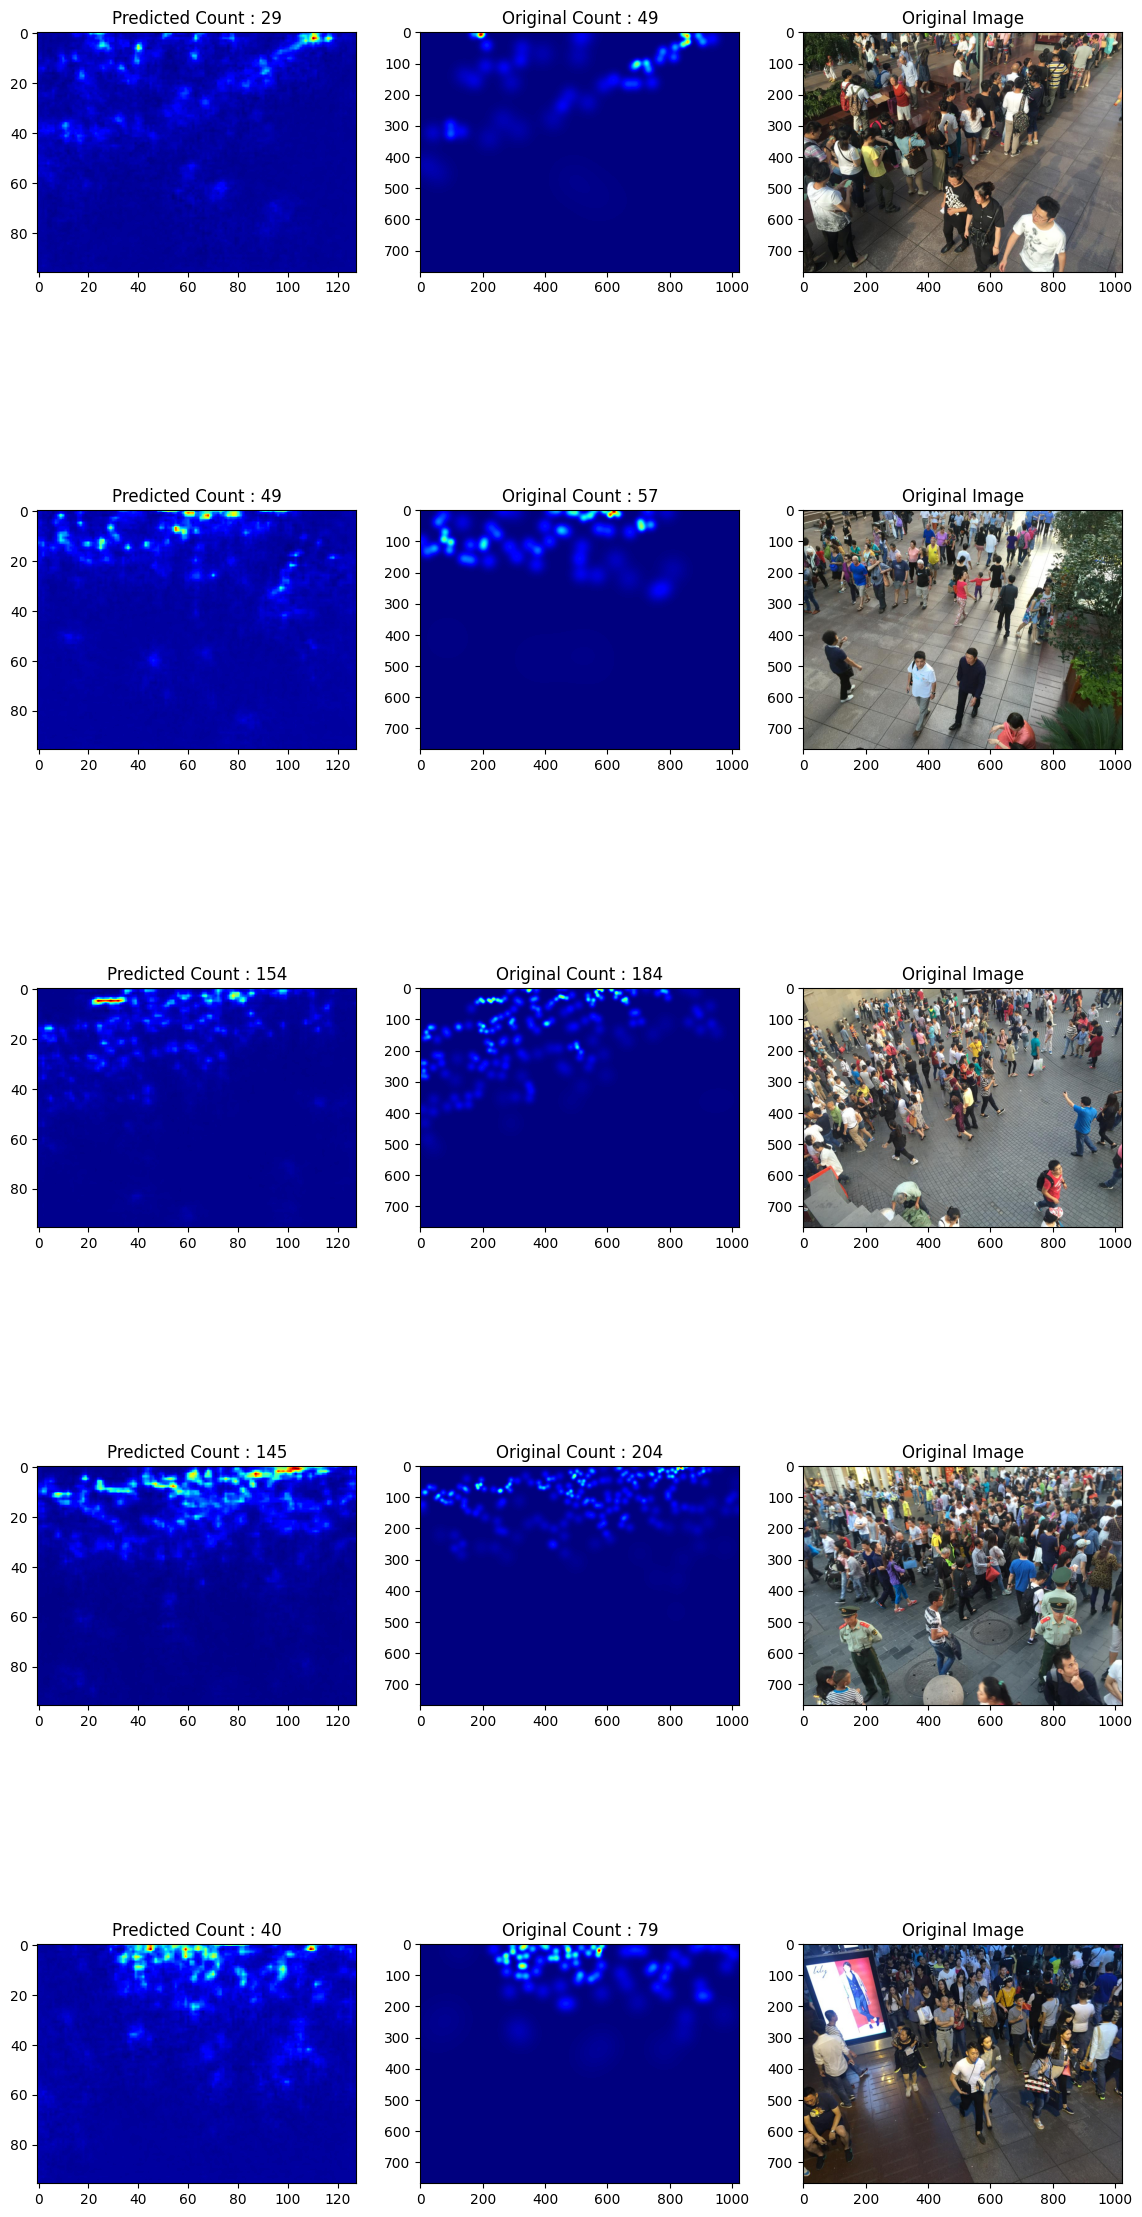

In [ ]:
# visualize
fig,ax = plt.subplots(nrows = 5,ncols = 3,figsize = (14,30) )
for i in range(5):
  img_path = test_image_list[i]
  transform = transforms.Compose([
                                  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                              std=[0.229, 0.224, 0.225]),
                              ])
  img = transform(Image.open(test_image_list[i]).convert('RGB')).cuda()
  output = model(img.unsqueeze(0))
  temp_title = "Predicted Count : "+str(int(output.detach().cpu().sum().numpy()))
  temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
  ax[i][0].imshow(temp,cmap = c.jet)
  ax[i][0].set_title(temp_title)

  temp = h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth-h5'), 'r')
  temp_1 = np.asarray(temp['density'])
  ax[i][1].imshow(temp_1,cmap = c.jet)
  ax[i][1].set_title("Original Count : "+str(int(np.sum(temp_1)) + 1))

  ax[i][2].set_title("Original Image")
  ax[i][2].imshow(plt.imread(img_path))




In [ ]:
best_checkpoint = torch.load(PRETRAINED_MODEL)
model = CSRNet()

model = model.cuda()

criterion = nn.MSELoss(size_average=False).cuda()

# optimizer = torch.optim.SGD(model.parameters(), args.lr,
#                             momentum=args.momentum,
#                             weight_decay=args.decay)
model.load_state_dict(best_checkpoint['state_dict'])
# optimizer.load_state_dict(best_checkpoint['optimizer'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


<All keys matched successfully>

In [ ]:
!unzip students_validation.zip

Archive:  students_validation.zip
  inflating: IMG_1.jpg               
  inflating: IMG_16.jpg              
  inflating: IMG_18.jpg              
  inflating: IMG_23.jpg              
  inflating: IMG_37.jpg              
  inflating: IMG_6.jpg               


In [ ]:
student_val_list = ['./IMG_16.jpg','./IMG_18.jpg','./IMG_37.jpg','./IMG_6.jpg','IMG_20.jpg']

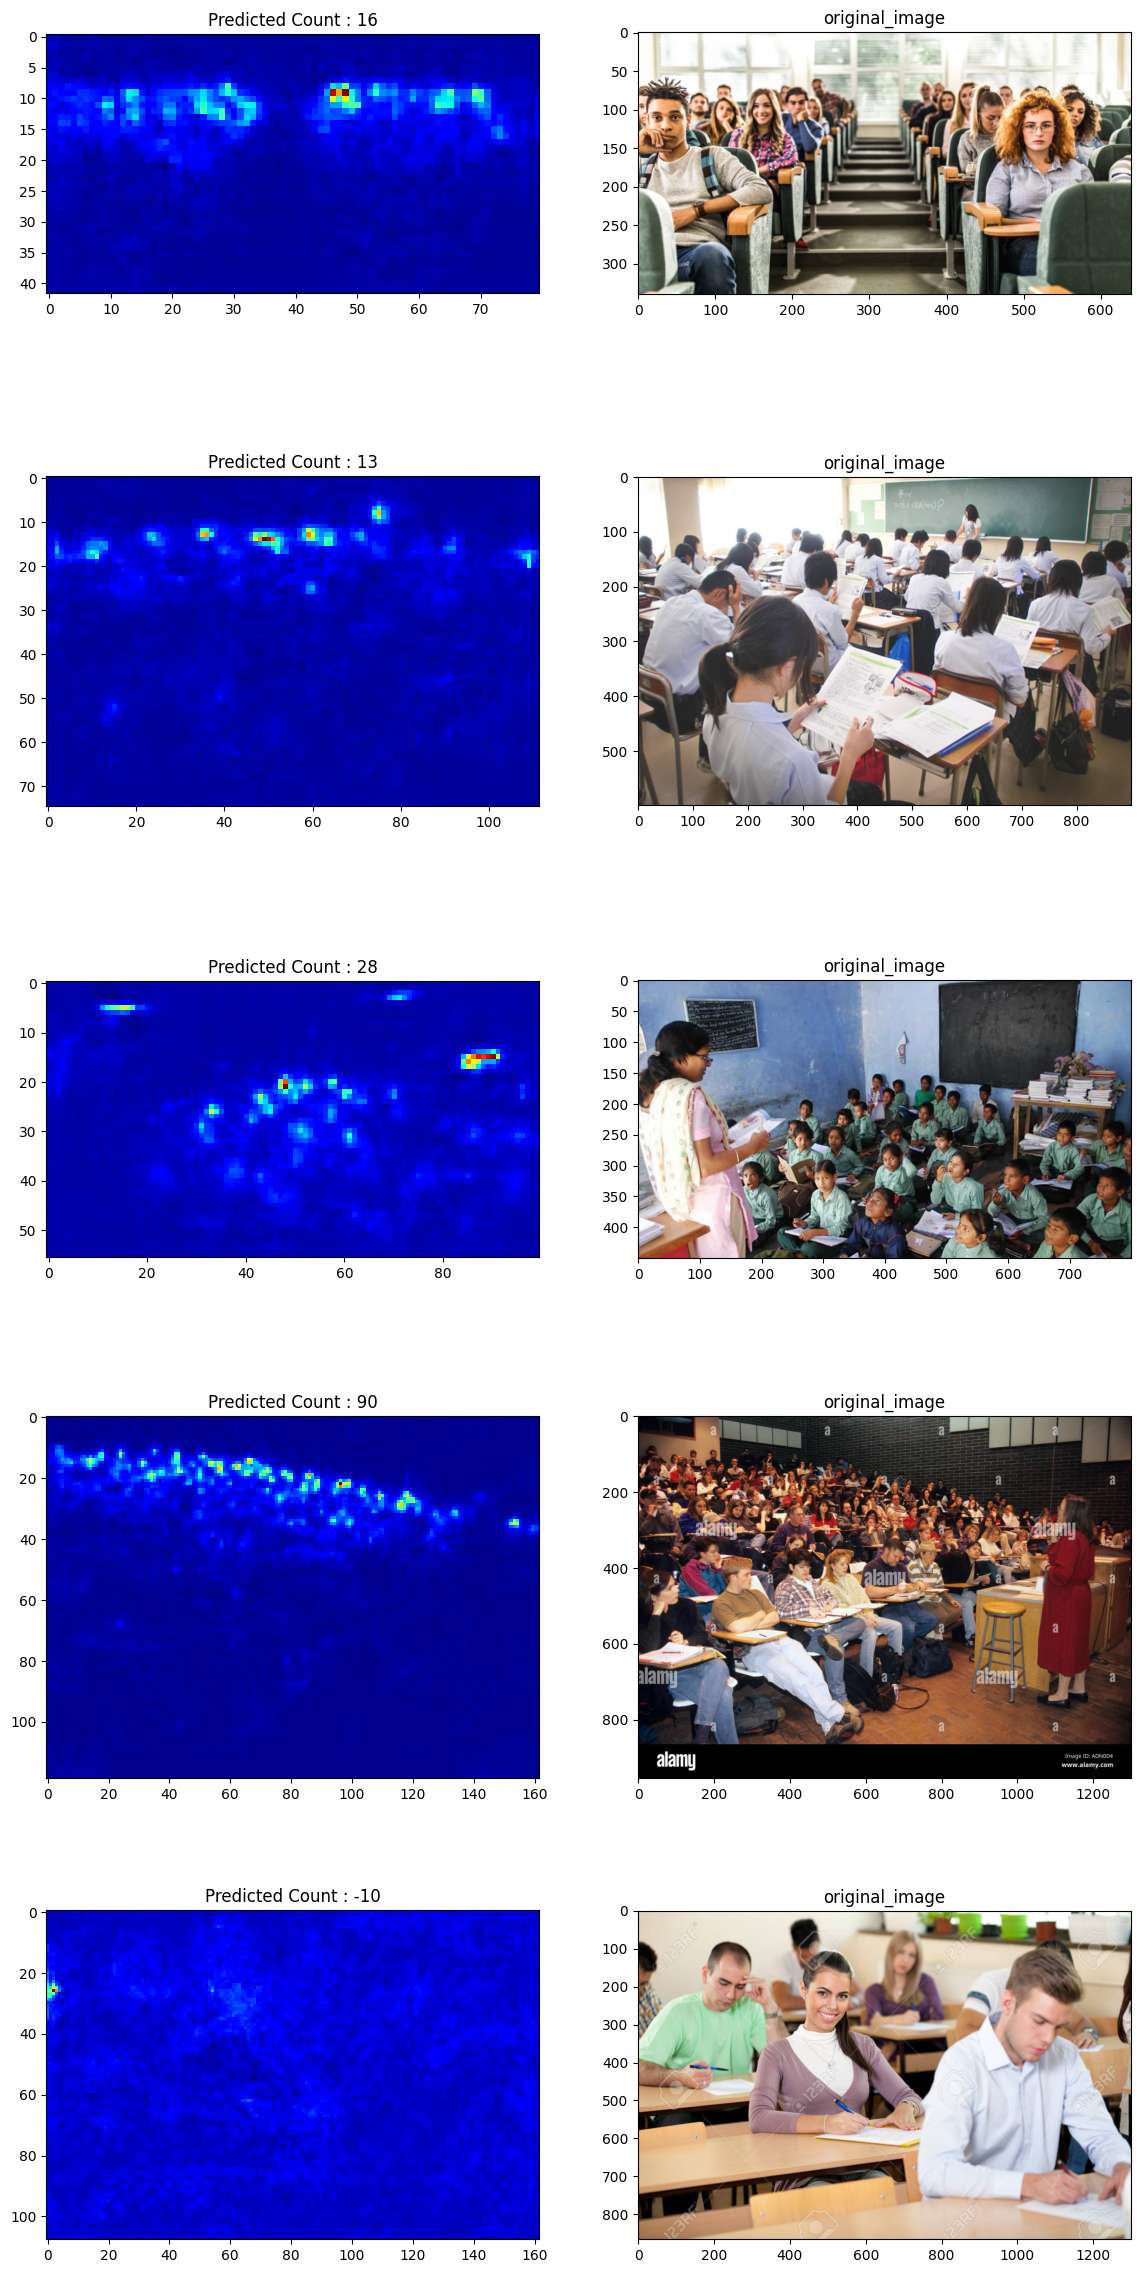

In [ ]:
fig,ax = plt.subplots(nrows = 5,ncols = 2,figsize = (14,30))
for i in range(5):
  transform=transforms.Compose([
                                  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                              std=[0.229, 0.224, 0.225]),
                              ])

  from matplotlib import cm as c
  img = transform(Image.open(student_val_list[i]).convert('RGB')).cuda()
  output = model(img.unsqueeze(0))
  ax[i][1].set_title("original_image")
  ax[i][1].imshow(plt.imread(student_val_list[i]))
  temp = "Predicted Count : "+str(int(output.detach().cpu().sum().numpy()))
  ax[i][0].set_title(temp
                     )
  temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
  ax[i][0].imshow(temp,cmap = c.jet)
